# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

In [121]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [123]:
df.sort_index(inplace=True, ascending=True)

# Data analysis

First, explore the time series.

## Plot time series

## Basic time plot

<Axes: xlabel='week'>

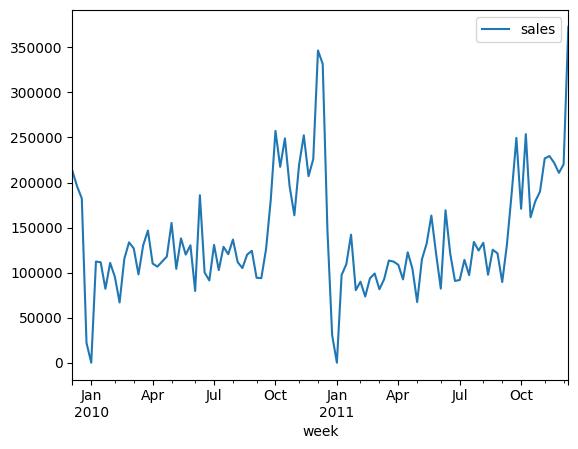

In [124]:
df.plot()

## Observations
* Not clear whether there is an overall trend
* Reliably see increased sales towards the end of the year from October, which drops off in January
* Some seasonality mid-year with the spikyness we see between February and October
* Don't immediately see any outlying values that are too big or small
* All sales data is > 0

## Plot by month

C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Sales distribution per month of year')]

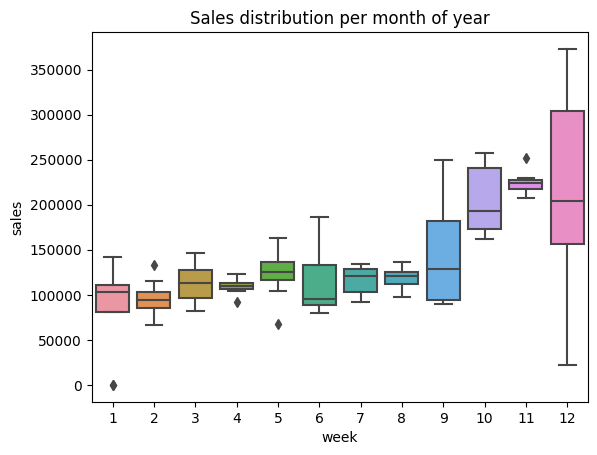

In [125]:
sns.boxplot(
    data=df,
    x=df.index.month,
    y="sales"
).set(title="Sales distribution per month of year")

<Axes: xlabel='week'>

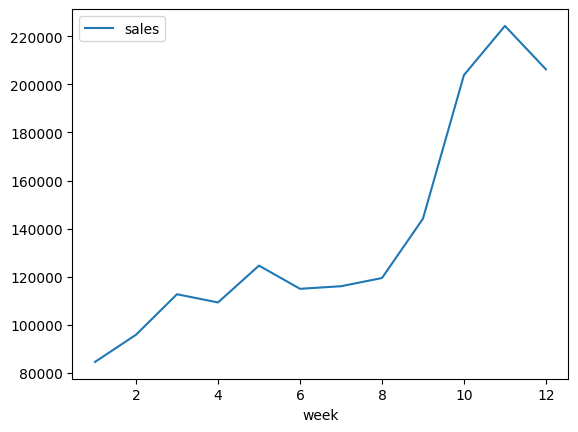

In [126]:
df.groupby(df.index.month)[["sales"]].mean().plot()

## Observations
* Marked increase from month 9 onward peaking in month 12
* Fairly tight distributions for the first 5 months of the year with some increased variability in June which falls off towards end of summer before reaching month 9

## Plot by day

<Axes: xlabel='week'>

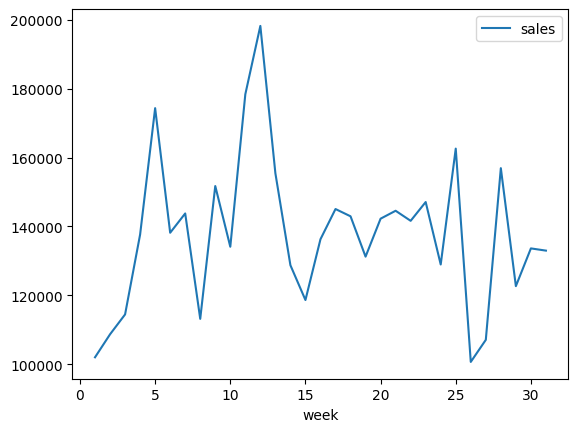

In [127]:
df.groupby(df.index.day)[["sales"]].mean().plot()

C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Sales distribution per day of week')]

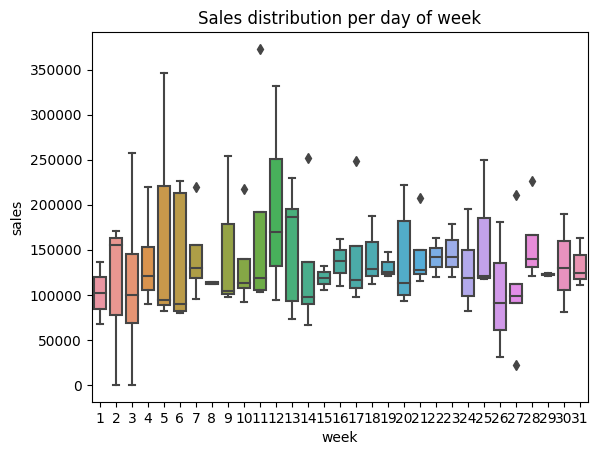

In [128]:
sns.boxplot(
    data=df,
    x=df.index.day,
    y="sales"
).set(title="Sales distribution per day of week")

## Observations
* Box plot not clear but line chart much clearer
* Definitely see some seasonality within the days of the month. For example mid-month is reliably poor for sales but the start of the month seems much more variable.

## Plot by weekend/weekday

Seems every sale has been made only on a Sunday or the sales have been summed up per week to the Sunday so we don't have more granular data than what we have already looked at.

In [129]:
df.index.weekday.value_counts()

week
6    106
Name: count, dtype: int64

## Missing data

Check if there are missing values in the time series.

In [130]:
df.isnull().sum()

sales    0
dtype: int64

In [131]:
df.isna().sum()

sales    0
dtype: int64

No missing data. That is to say, for the given timestamps, each timestamp has a non-null value of sales.

## Missing timestamps

Check if there are missing timestamps in the index.

In [132]:
import numpy as np
df.asfreq("W", fill_value=np.NaN).isnull().sum()

sales    0
dtype: int64

In [133]:
df.query("sales == 0")

,sales
week,
2010-01-03,0.0
2011-01-02,0.0


## Commentary
* No missing timestamps
* Do have two dates which have 0 sales but they are both right at the start of the year implying to me that the store was closed prior to the new year, as opposed to the data being missing

## Seasonality

Does the time series show any obvious seasonal pattern?

Yes, seen above in the initial plots

# Feature engineering

Now, let's begin to tabularize the data.

## Add time related features

In [134]:
def add_time_related_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        month=lambda df: df.index.month,
        week=lambda df: df.index.isocalendar().week,
        day=lambda df: df.index.day
    )
df = add_time_related_features(df)
df.head(3)

,sales,month,week,day
week,,,,
2009-12-06,213000.35,12,49,6
2009-12-13,195810.04,12,50,13
2009-12-20,182396.74,12,51,20


## Add lag features

In [135]:
def get_lag_var(df: pd.DataFrame, period: int, var: str = "sales") -> pd.Series:
    df_shifted = df[var].shift(freq=f"{period}W")
    return df_shifted.rename(f"{var}_lag_{period}")

In [136]:
print(df.shape)
for period in [1, 4]:
    df=df.merge(get_lag_var(df, period=period), left_index=True, right_index=True, how="left")
print(df.shape)
df.head(3)

(106, 4)
(106, 6)


,sales,month,week,day,sales_lag_1,sales_lag_4
week,,,,,,
2009-12-06,213000.35,12,49,6,NaN,NaN
2009-12-13,195810.04,12,50,13,213000.35,NaN
2009-12-20,182396.74,12,51,20,195810.04,NaN


## Add windowed features

In [137]:
def get_mean_window_feat(df, weeks: int, freq: str = "1W", var: str = "sales"):
    window = f"{7*weeks}D"
    return (
        df
        .loc[:, var]
        .rolling(window=window)
        .mean()
        .shift(freq=freq)
        .rename(f"{var}_window_{window}")
    )

In [138]:
print(df.shape)
for weeks in [3, 6]:
    df=df.merge(get_mean_window_feat(df, weeks=weeks), left_index=True, right_index=True, how="left")
print(df.shape)


(106, 6)
(106, 8)


# Periodic features

In [139]:
cyclical = CyclicalFeatures(
    variables=["month", "week", "day"],
    drop_original=True
)
df = cyclical.fit_transform(df)
df.head(3)

,sales,sales_lag_1,sales_lag_4,sales_window_21D,sales_window_42D,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos
week,,,,,,,,,,,
2009-12-06,213000.35,NaN,NaN,NaN,NaN,-2.449294e-16,1.0,-0.456629,0.889657,0.937752,0.347305
2009-12-13,195810.04,213000.35,NaN,213000.350,213000.350,-2.449294e-16,1.0,-0.348202,0.93742,0.485302,-0.874347
2009-12-20,182396.74,195810.04,NaN,204405.195,204405.195,-2.449294e-16,1.0,-0.234886,0.972023,-0.790776,-0.612106


# Missing data?

In [140]:
# Determine fraction of missing data.
df.isnull().sum() / len(df)

sales               0.000000
sales_lag_1         0.009434
sales_lag_4         0.037736
sales_window_21D    0.009434
sales_window_42D    0.009434
month_sin           0.000000
month_cos           0.000000
week_sin            0.000000
week_cos            0.000000
day_sin             0.000000
day_cos             0.000000
dtype: float64

pretty small so will just drop

In [141]:
df_final = df.dropna()
print(df.shape, df_final.shape)

(106, 11) (102, 11)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [142]:
df_final.index.max()

Timestamp('2011-12-11 00:00:00')

In [143]:
target = "sales"
feats = [x for x in df_final.columns if x != target]
cutoff_date = "2011-09-01"

df_final_train = df_final.query("week < @cutoff_date")
df_final_test = df_final.query("week >= @cutoff_date")

X_train = df_final_train.loc[:, feats]
X_test = df_final_test.loc[:, feats]

y_train = df_final_train.loc[:, target]
y_test = df_final_test.loc[:, target]

print("x train, test shapes", X_train.shape, X_test.shape)
print("y train, test shapes", y_train.shape, y_test.shape)

x train, test shapes (87, 10) (15, 10)
y train, test shapes (87,) (15,)


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [144]:
def naive_forecast(X_train, y_train, X_test, y_test, lag1_col = "sales_lag_1"):

    print("train rmse: ", mean_squared_error(
        y_train, X_train[lag1_col], squared=False,))

    print("test rmse: ",  mean_squared_error(
        y_test, X_test[lag1_col], squared=False,))

In [145]:
naive_forecast(X_train, y_train, X_test, y_test)

train rmse:  45673.6110883686
test rmse:  61487.22119875264


## Machine Learning

In [146]:
from typing import Tuple

In [147]:
def train_and_eval_models(X_train, y_train, X_test, y_test) -> Tuple[list[str], list[float], list[float]]:

    models = {
        "rf": RandomForestRegressor(n_estimators=50, max_depth=3),
        "linear_regression": LinearRegression(),
        "lasso": Lasso(),
        "ridge": Ridge(),
        "ElasticNet": ElasticNet()
    }

    train_rmse = []
    test_rmse = []

    for name, model in models.items():
        print(name)
        model.fit(X_train, y_train)
        train_rmse.append(
            mean_squared_error(y_train, model.predict(X_train), squared=False)
        )
        test_rmse.append(
            mean_squared_error(y_test, model.predict(X_test), squared=False)
        )
    return models, train_rmse, test_rmse

In [148]:
fitted_models, train_rmse, test_rmse = train_and_eval_models(X_train, y_train, X_test, y_test)

rf
linear_regression
lasso
ridge
ElasticNet


C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\RonanDiver\Desktop\repos\feature-engineering-fo

[Text(0.5, 1.0, 'train_rmse')]

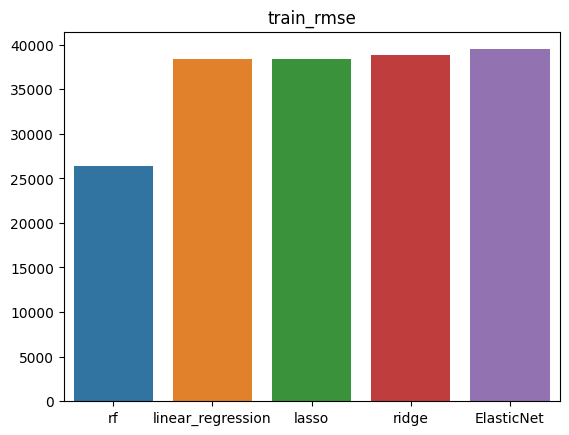

In [149]:
sns.barplot(
    x=list(fitted_models.keys()),
    y=train_rmse
).set(title="train_rmse")

C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\RonanDiver\Desktop\repos\feature-engineering-for-time-series-forecasting\venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\RonanDiver\Desktop\repos\feature-engineering-fo

[Text(0.5, 1.0, 'test_rmse')]

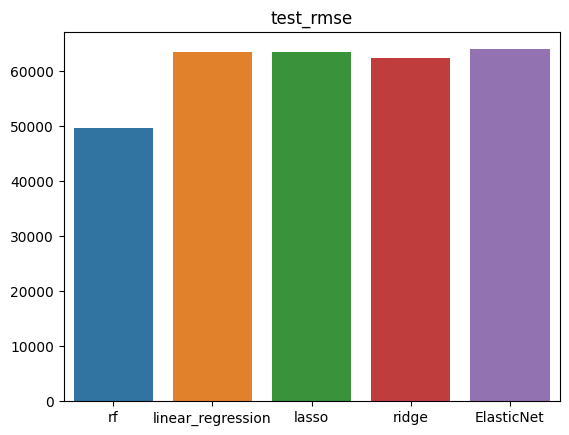

In [150]:
sns.barplot(
    x=list(fitted_models.keys()),
    y=test_rmse
).set(title="test_rmse")

In [151]:
# recall naive forecast and compare to rf which is slight winner
naive_forecast(X_train, y_train, X_test, y_test)

train rmse:  45673.6110883686
test rmse:  61487.22119875264


In [152]:
print("rf train rmse: ", train_rmse[0])
print("rf test rmse: ", test_rmse[0])

rf train rmse:  26378.678444336823
rf test rmse:  49552.83764465667


Text(0, 0.5, 'Importance')

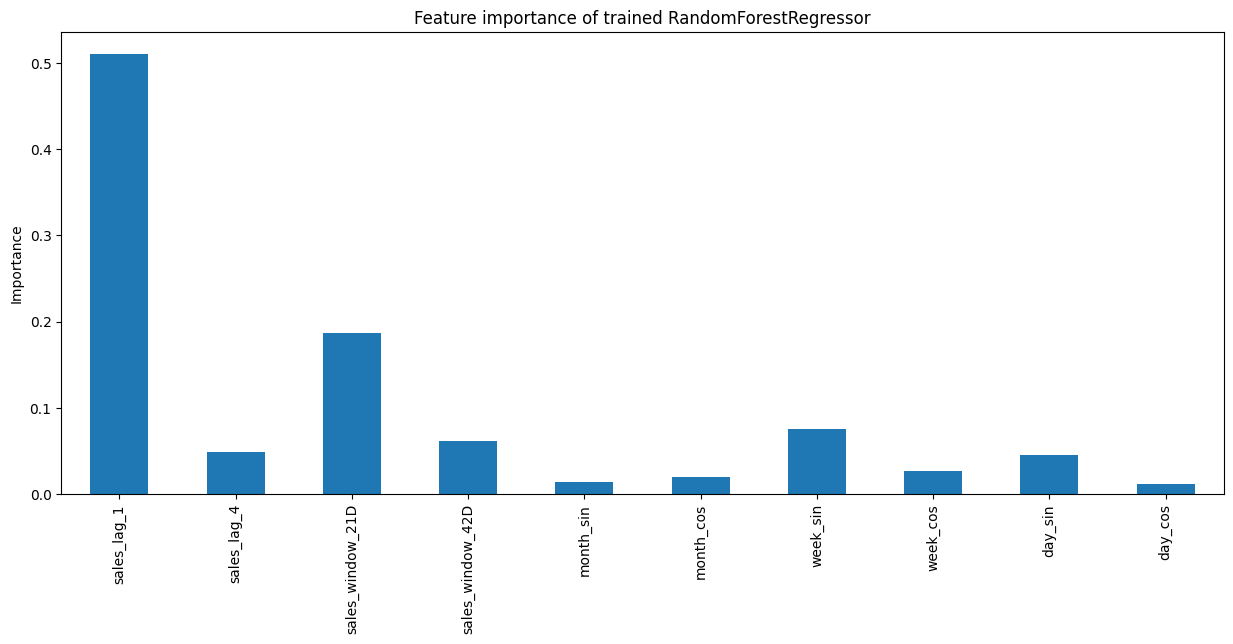

In [153]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(fitted_models['rf'].feature_importances_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance of trained RandomForestRegressor")
plt.ylabel("Importance")